# Journey for Policy Makers
Econ-ARK is a powerful toolbox to solve heterogeneous agent models. Users can run off-the shelf models or use tools to build their own agent or model type. While there are many notebooks which introduce and describe different agents and tools it might be overwhelming at first.

This guide tries to introduce HARK and point out the most important notebooks, model types, and tools such that users can get quickly up to speed to analyze macroeconomic shocks. For this, we will:

1. Introduction into HARK
2. From HARK to HANK
3. Why use HARK?

Author: Adrian Monninger

## 1. Introduction into HARK

Heterogenous Agents Resources & toolKit (HARK) is a toolkit for the structural modeling of economic choices of optimizing and non-optimizing heterogeneous agents.

HARK is software written in Python. This is the documentation for that software. It is aimed at computational researchers and other software developers who are building new models with HARK, or are contributing to the core software.

[Econ-ark](https://github.com/econ-ark) contains the three main repositories [HARK](https://github.com/econ-ark/HARK), [DemARK](https://github.com/econ-ark/DemARK), and [RemARK](https://github.com/econ-ark/RemARK). On top of that, there is an [online documentation](https://hark.readthedocs.io/en/latest/), as well as the [website](https://econ-ark.org/) which combines all of them. Hence, if you want to find a notebook search them in [materials](https://econ-ark.org/materials).

- HARK: Includes the source code as well as some example notebooks.
- DemARK: Here you can find Demonstrations of tools, AgentTypes, and ModelClasses.
- RemARK: Here you can find R[eplications/eproductions] and Explorations Made using ARK.



## 1.1 Structure
Econ-ark has two types of classes. One for the micro level called: `AgentType` and one for the macro level called: `Market`. 

To understand the microeconomic models in HARK, you need to have some concept of the Agent-type class structure. In HARK more advanced models are subclasses of the more primitive ones. The diagram, illustrates this structure: the deterministic class `PerfForesightConsumerType`, is then a parent for the class of the consumers with idiosyncratic income shocks `IndShockConsumerType`. Next there is a class with the idiosyncratic and aggregate income shocks `𝙼𝚊𝚛𝚔𝚘𝚟ConsumerType`. However, it is not the end! There are subclass of the `AggShockConsumerType` which are designed to be integrated with the macroeconomic models, as well as there are many other subclasses.

![HARK structure](HARK_struct_2.png)

As in case of the agent-type the more complicated macroeconomic models are the subclasses of the more primitive ones. The subclasses of Market include `CobbDouglasEconomy` and `SmallOpenEconomy`. The main difference between them is that for `CobbDouglasEconomy`, the capital and labour prices are endogenous, while in the (small) open economy class there are set exogenously. Nevertheless, both basic classes enable the aggregate fluctuation in the economy, that is:

\begin{eqnarray*} 
Y_{i,t}  &=& \varepsilon_t(\epsilon_{i,t}p_{i,t}\Theta_t P_t )\\
P_{t+1} &=& P_{t}\Psi_{t+1}\\
\Psi_{t}  &\sim & {N}(1,\sigma_{\Psi})\\
\Theta_t  &\sim &{N}(1,\sigma_{\Theta})\\
\end{eqnarray*}

Therefore, the consumers, which are attributes of such market classes, need to include the aggregate fluctuations of the whole economy in their optimization problem. This is the reason why the `AggShockConsumerType` consumer type class (and their subclasses) must be used to construct the macro-model. 

The subclass of `CobbDouglasEconomy` is `CobbDouglasMarkovEconomy`. In this setting, in the economy there exist an additional aggregate fluctuation, which distribution is given by the finite Markov matrix. 

![HARK structure2](HARK_struct_4.png)


## 1.2 Example: `IndShockConsumerType`
This type is our standard one where the household faces idiosyncratic permanent and transitory shocks. Other shocks can be added by changing parameters (unemployment, retirement)

It is extremely easy to [use](https://github.com/econ-ark/HARK/blob/master/examples/ConsIndShockModel/IndShockConsumerType.ipynb). A small illustration is below solving an infinite horizon and lifecycle problem.

In [1]:
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType
from HARK.utilities import plot_funcs_der, plot_funcs
import matplotlib.pyplot as plt
import numpy as np

### An infinite horizon Problem

In [15]:
# Specify a dictionary
IdiosyncDict={
    # Parameters shared with the perfect foresight model
    "CRRA": 2.0,                           # Coefficient of relative risk aversion
    "Rfree": 1.03,                         # Interest factor on assets
    "DiscFac": 0.96,                       # Intertemporal discount factor
    "LivPrb" : [0.99,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1],
    "PermGroFac" : [1.01,1.01,1.01,1.02,1.02,1.02,0.7,1.0,1.0,1.0],
    
    # Parameters that specify the income distribution over the lifecycle
    "PermShkStd" : [0.1,0.2,0.1,0.2,0.1,0.2,0.1,0,0,0],
    "PermShkCount" : 7,                    # Number of points in discrete approximation to permanent income shocks
    "TranShkStd" : [0.3,0.2,0.1,0.3,0.2,0.1,0.3,0,0,0],
    "TranShkCount" : 7,                    # Number of points in discrete approximation to transitory income shocks
    "UnempPrb" : 0.05,                     # Probability of unemployment while working
    "IncUnemp" : 0.3,                      # Unemployment benefits replacement rate
    "UnempPrbRet" : 0.0005,                # Probability of "unemployment" while retired
    "IncUnempRet" : 0.0,                   # "Unemployment" benefits when retired
    "T_retire" : 7,                        # Period of retirement (0 --> no retirement)
    "tax_rate" : 0.0,                      # Flat income tax rate (legacy parameter, will be removed in future)
    
    # Parameters for constructing the "assets above minimum" grid
    "aXtraMin" : 0.001,                    # Minimum end-of-period "assets above minimum" value
    "aXtraMax" : 20,                       # Maximum end-of-period "assets above minimum" value
    "aXtraCount" : 48,                     # Number of points in the base grid of "assets above minimum"
    "aXtraNestFac" : 3,                    # Exponential nesting factor when constructing "assets above minimum" grid
    "aXtraExtra" : [None],                 # Additional values to add to aXtraGrid
    
    # A few other paramaters
    "BoroCnstArt" : 0.0,                   # Artificial borrowing constraint; imposed minimum level of end-of period assets
    "vFuncBool" : True,                    # Whether to calculate the value function during solution   
    "CubicBool" : False,                   # Preference shocks currently only compatible with linear cFunc
    "T_cycle" : 10,                        # Number of periods in the cycle for this agent type        
    
    # Parameters only used in simulation
    "AgentCount" : 10000,                  # Number of agents of this type
    "T_sim" : 120,                         # Number of periods to simulate
    "aNrmInitMean" : -6.0,                 # Mean of log initial assets
    "aNrmInitStd"  : 1.0,                  # Standard deviation of log initial assets
    "pLvlInitMean" : 0.0,                  # Mean of log initial permanent income
    "pLvlInitStd"  : 0.0,                  # Standard deviation of log initial permanent income
    "PermGroFacAgg" : 1.0,                 # Aggregate permanent income growth factor
    "T_age" : 11,                          # Age after which simulated agents are automatically killed     
}

In [16]:
# Specify agent
IndShockExample_inf = IndShockConsumerType(**IdiosyncDict)
IndShockExample_inf.cycles = 0 # Make this type have an infinite horizon

In [17]:
# Solve
IndShockExample_inf.solve()

Consumption function for an idiosyncratic shocks consumer type:


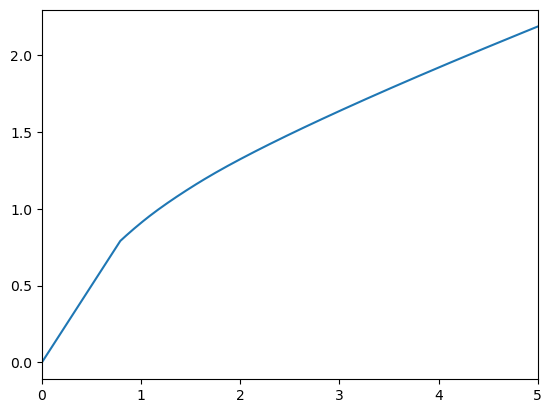

Marginal propensity to consume for an idiosyncratic shocks consumer type:


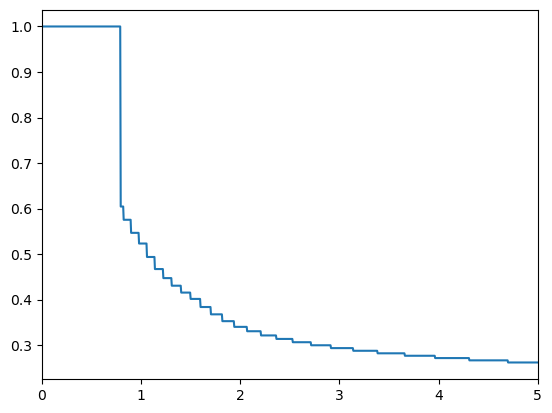

In [18]:
# Show
print('Consumption function for an idiosyncratic shocks consumer type:')
plot_funcs(IndShockExample_inf.solution[0].cFunc, IndShockExample_inf.solution[0].mNrmMin,5)
print('Marginal propensity to consume for an idiosyncratic shocks consumer type:')
plot_funcs_der(IndShockExample_inf.solution[0].cFunc, IndShockExample_inf.solution[0].mNrmMin,5)

### A lifecycle Problem

In [22]:
LifecycleExample = IndShockConsumerType(**IdiosyncDict)
LifecycleExample.cycles = 1 # Make this consumer live a sequence of periods -- a lifetime -- exactly once
LifecycleExample.solve()
print('First element of solution is',LifecycleExample.solution[0])
print('Solution has', len(LifecycleExample.solution),'elements.')

First element of solution is <HARK.ConsumptionSaving.ConsIndShockModel.ConsumerSolution object at 0x000001AA27B36EB0>
Solution has 11 elements.


Consumption functions across the lifecycle:


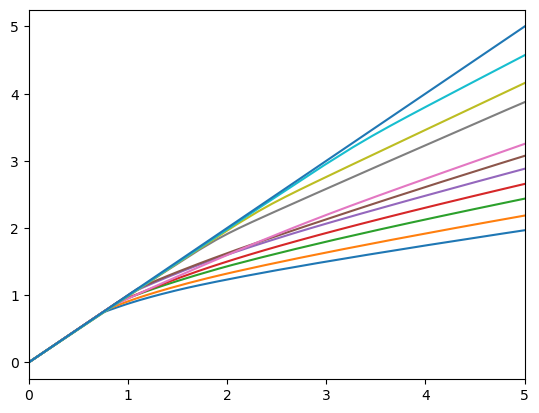

In [20]:
print('Consumption functions across the lifecycle:')
mMin = np.min([LifecycleExample.solution[t].mNrmMin for t in range(LifecycleExample.T_cycle)])
LifecycleExample.unpack('cFunc') # This makes all of the cFuncs accessible in the attribute cFunc
plot_funcs(LifecycleExample.cFunc,mMin,5)

We easily can adjust the parameters to make them time varying as well!

### 2.3 Simulation
We can simulate using Monte Carlo or [Transition Matrices](https://github.com/econ-ark/HARK/tree/master/examples/ConsIndShockModel/IndShockConsumerType_Transition_Matrix_Example.ipynb)

# 2. From HARK to HANK
HARK has a huge variety of models on the partial equilibrium side. How to include the general equilibrium side? There are multiple options.

a) Krusell-Smith

In line with every other toolbox, we have our own [Krusell-Smith Model](https://github.com/econ-ark/KrusellSmith/blob/master/Code/Python/KrusellSmith.ipynb)


b) Bayer Luetticke

[Bayer Luetticke Method](https://github.com/econ-ark/BayerLuetticke) This seems to be half-baked

c) Sequence Space Jacobian

Our favorite method is to use HARK for the heterogeneous household part, solve the steady state values and jacobians, plug them in the sequence space toolbox and get all their nice functions for free!

LINK TO FISCAL NOTEBOOK

In [ ]:
LINK TO MONETARY NOTEBOOK (IF READY)

## 3. Why use HARK?
The question might now arrise: Why should I learn a new Toolkit and not stick to SSJ completely.

With HARK you have a lot of flexibility on the heterogeneous agent part!

### 3.1 Targeting liquid asset distribution
Before, we targeted mean assets (SSJ targets mean MPC). But, what about the whole distribution?
Here is a [demonstration](https://github.com/econ-ark/DemARK/blob/master/notebooks/Micro-and-Macro-Implications-of-Very-Impatient-HHs.ipynb) which shows how to targe the asset distribution allowing for ex ante heterogeneity in discount factors.

### 3.2 Other HARK agents
There are many more off-the-shelf agents waiting to be used.


ConsAggShockModel.py

ConsGenIncProcessModel.py

ConsLaborModel.py

ConsMarkovModel.py

ConsMedModel.py

ConsPortfolioFrameModel.py

ConsPortfolioModel.py

ConsPrefShockModel.py

ConsRepAgentModel.py

ConsRiskyAssetModel.py

ConsRiskyContribModel.py

TractableBufferStockModel.py


#### a) [Portfolio Choice](https://github.com/econ-ark/HARK/blob/master/examples/ConsPortfolioModel/example_ConsPortfolioModel.ipynb)

Using the `PortfolioConsumerType` allows you to add risky assets as well. For this, you can specify
- a share of risky asset holder exogeneously
- solving the share endogeneously with participation costs 
- Vary returns by age
- ...

#### b) Search and matching model [HANK and SAM]

#### c) [Durable Good](https://github.com/AMonninger/DurableConsumerType_REMARK/blob/main/code/python/DurableModel_Notebook.ipynb)      

Using `DurableConsumerType`allows you to solve a problem with non-durable and durable goods, where there exist a non-convex adjustment cost.

### 3.3 Build your own Agent
In case your research question requires additional featuers off-the-shelf models do not have, you can include them relatively easy!

As we have seen above, agents inherit features from other agents. Hence, search for the closest agenttype and replace the parts you want to change.

#### a) Understanding the code
Obviously, the most important thing is to understand the structure of the code. Then you can think about which code to replace and how.
A good starting point is this [notebook](https://github.com/econ-ark/HARK/blob/master/examples/HowWeSolveIndShockConsumerType/HowWeSolveIndShockConsumerType.ipynb) describing how we solve the `IndShockConsumerType`. Then look at the source code ofe other models which build on this one eg [`IndShockRiskyAssetConsumerType`](https://github.com/econ-ark/HARK/blob/master/HARK/ConsumptionSaving/ConsRiskyAssetModel.py)


#### b) Use our tools
We update our toolbox constantly. Hence, there might be something in for your current problem. For many of them exist notebooks to showcase their function.

Useful examples are:
- [DCEGM-Upper-Envelope](https://github.com/econ-ark/DemARK/blob/master/notebooks/DCEGM-Upper-Envelope.ipynb): To solve problems with nonconex value functions due to discrete choices
- [Harmenberg-Aggregation](https://github.com/econ-ark/DemARK/blob/master/notebooks/Harmenberg-Aggregation.ipynb): EXPLANATION
- [DecayInterp](https://github.com/econ-ark/HARK/tree/master/examples/Interpolation/DecayInterp.ipynb): Interpolation with decay for instnace, if there is an analytical limit
- ...





# APPENDIX

# List of materials on HARK
1. Calibration (no notebooks)
[Income_calibrations](https://github.com/econ-ark/HARK/tree/master/examples/Calibration/Income_calibrations.py)
[Life_Cycle_example](https://github.com/econ-ark/HARK/tree/master/examples/Calibration/Life_Cycle_example.py)
[SCF_distributions](https://github.com/econ-ark/HARK/tree/master/examples/Calibration/SCF_distributions.py)
[Sabelhaus_Song_var_profiles](https://github.com/econ-ark/HARK/tree/master/examples/Calibration/Sabelhaus_Song_var_profiles.py)
[US_SSA_life_tables](https://github.com/econ-ark/HARK/tree/master/examples/Calibration/US_SSA_life_tables.py)

2. ConsIndShockModel
[Finite Cyclical Test](https://github.com/econ-ark/HARK/tree/master/examples/ConsIndShockModel/Finite Cyclical Test.ipynb)
[IndShockConsumerType](https://github.com/econ-ark/HARK/tree/master/examples/ConsIndShockModel/IndShockConsumerType.ipynb)
[IndShockConsumerType_Jacobian_Example](https://github.com/econ-ark/HARK/tree/master/examples/ConsIndShockModel/IndShockConsumerType_Jacobian_Example.ipynb)
[IndShockConsumerType_Transition_Matrix_Example](https://github.com/econ-ark/HARK/tree/master/examples/ConsIndShockModel/IndShockConsumerType_Transition_Matrix_Example.ipynb)
[KinkedRconsumerType](https://github.com/econ-ark/HARK/tree/master/examples/ConsIndShockModel/KinkedRconsumerType.ipynb)
[PerfForesightConsumerType](https://github.com/econ-ark/HARK/tree/master/examples/ConsIndShockModel/PerfForesightConsumerType.ipynb)

3. ConsPortfolioModel
[example_ConsPortfolioModel](https://github.com/econ-ark/HARK/tree/master/examples/ConsPortfolioModel/example_ConsPortfolioModel.ipynb)
[example_ConsRiskyAssetModel](https://github.com/econ-ark/HARK/tree/master/examples/ConsPortfolioModel/example_ConsRiskyAssetModel.ipynb)
[example_ConsSequentialPortfolioModel](https://github.com/econ-ark/HARK/tree/master/examples/ConsPortfolioModel/example_ConsSequentialPortfolioModel.ipynb)

4. ConsumptionSaving (Outdated)
[example_ConsAggShockModel](https://github.com/econ-ark/HARK/blob/master/examples/ConsumptionSaving/example_ConsAggShockModel.ipynb)
[example_ConsGenIncProcessModel](https://github.com/econ-ark/HARK/blob/master/examples/ConsumptionSaving/example_ConsGenIncProcessModel.ipynb)
[example_ConsIndShock](https://github.com/econ-ark/HARK/blob/master/examples/ConsumptionSaving/example_ConsIndShock.ipynb)
[example_ConsLaborModel](https://github.com/econ-ark/HARK/blob/master/examples/ConsumptionSaving/example_ConsLaborModel.ipynb)
[example_ConsMarkovModel](https://github.com/econ-ark/HARK/blob/master/examples/ConsumptionSaving/example_ConsMarkovModel.ipynb)
[example_ConsMedModel](https://github.com/econ-ark/HARK/blob/master/examples/ConsumptionSaving/example_ConsMedModel.ipynb)
[example_ConsPrefShockModel](https://github.com/econ-ark/HARK/blob/master/examples/ConsumptionSaving/example_ConsPrefShockModel.ipynb)
[example_ConsRepAgentModel](https://github.com/econ-ark/HARK/blob/master/examples/ConsumptionSaving/example_ConsRepAgentModel.ipynb)
[example_ConsRiskyContribModel](https://github.com/econ-ark/HARK/blob/master/examples/ConsumptionSaving/example_ConsRiskyContribModel.py) No notebook
[example_TractableBufferStockModel](https://github.com/econ-ark/HARK/blob/master/examples/ConsumptionSaving/example_TractableBufferStockModel.ipynb)


5. Distributions
[DiscreteDistributionLabeled](https://github.com/econ-ark/HARK/tree/master/examples/Distributions/DiscreteDistributionLabeled.ipynb)
[ExpectedValue](https://github.com/econ-ark/HARK/tree/master/examples/Distributions/ExpectedValue.ipynb)

6. FrameAgentType (WIP)

7. GenIncProcessModel
[GenIncProcessModel](https://github.com/econ-ark/HARK/blob/master/examples/GenIncProcessModel/GenIncProcessModel.ipynb)

8. Gentle-Intro
[Gentle-Intro-To-HARK](https://github.com/econ-ark/HARK/blob/master/examples/Gentle-Intro/Gentle-Intro-To-HARK.ipynb)

9. HowWeSolveIndShockConsumerType
[HowWeSolveIndShockConsumerType](https://github.com/econ-ark/HARK/blob/master/examples/HowWeSolveIndShockConsumerType/HowWeSolveIndShockConsumerType.ipynb)

10. Interpolation
[CubicInterp](https://github.com/econ-ark/HARK/tree/master/examples/Interpolation/CubicInterp.ipynb)
[DecayInterp](https://github.com/econ-ark/HARK/tree/master/examples/Interpolation/DecayInterp.ipynb)

11. Journeys
[Journey_1_PhD](https://github.com/econ-ark/HARK/blob/master/examples/Journeys/Journey_1_PhD.ipynb)
[AzureMachineLearning](https://github.com/econ-ark/HARK/blob/master/examples/Journeys/AzureMachineLearning.ipynb)
[Journey 2 Engineering Background](https://github.com/econ-ark/HARK/blob/master/examples/Journeys/Journey%202%20Engineering%20Background.ipynb)

12. Lifecyclemodel
[EstimationParameters](https://github.com/econ-ark/HARK/blob/master/examples/LifecycleModel/EstimationParameters.py) --> Just a dictionary
[LifecycleModel](https://github.com/econ-ark/HARK/blob/master/examples/LifecycleModel/LifecycleModel.ipynb)


# List of Materials on DemARK
[Alternative-Combos-Of-Parameter-Values](https://github.com/econ-ark/DemARK/blob/master/notebooks/Alternative-Combos-Of-Parameter-Values.ipynb)
[ChangeLiqConstr](https://github.com/econ-ark/DemARK/blob/master/notebooks/ChangeLiqConstr.ipynb)
[Chinese-Growth](https://github.com/econ-ark/DemARK/blob/master/notebooks/Chinese-Growth.ipynb)
[DCEGM-Upper-Envelope](https://github.com/econ-ark/DemARK/blob/master/notebooks/DCEGM-Upper-Envelope.ipynb)
[DiamondOLG](https://github.com/econ-ark/DemARK/blob/master/notebooks/DiamondOLG.ipynb)
[FisherTwoPeriod](https://github.com/econ-ark/DemARK/blob/master/notebooks/FisherTwoPeriod)
[Gentle-Intro-To-HARK-Buffer-Stock-Model](https://github.com/econ-ark/DemARK/blob/master/notebooks/Gentle-Intro-To-HARK-Buffer-Stock-Model)
[Gentle-Intro-To-HARK-PerfForesightCRRA](https://github.com/econ-ark/DemARK/blob/master/notebooks/Gentle-Intro-To-HARK-PerfForesightCRRA)
[Harmenberg-Aggregation](https://github.com/econ-ark/DemARK/blob/master/notebooks/Harmenberg-Aggregation)
[IncExpectationExample](https://github.com/econ-ark/DemARK/blob/master/notebooks/IncExpectationExample)
[KeynesFriedmanModigliani](https://github.com/econ-ark/DemARK/blob/master/notebooks/KeynesFriedmanModigliani)
[LC-Model-Expected-Vs-Realized-Income-Growth](https://github.com/econ-ark/DemARK/blob/master/notebooks/LC-Model-Expected-Vs-Realized-Income-Growth.ipynb)
[LifeCycleModelTheoryVsData](https://github.com/econ-ark/DemARK/blob/master/notebooks/LifeCycleModelTheoryVsData)
[Lucas-Asset-Pricing-Model](https://github.com/econ-ark/DemARK/blob/master/notebooks/Lucas-Asset-Pricing-Model)
[MPC-Out-of-Credit-vs-MPC-Out-of-Income](https://github.com/econ-ark/DemARK/blob/master/notebooks/MPC-Out-of-Credit-vs-MPC-Out-of-Income.ipynb)
[Micro-and-Macro-Implications-of-Very-Impatient-HHs](https://github.com/econ-ark/DemARK/blob/master/notebooks/Micro-and-Macro-Implications-of-Very-Impatient-HHs.ipynb)
[Nondurables-During-Great-Recession](https://github.com/econ-ark/DemARK/blob/master/notebooks/Nondurables-During-Great-Recession.ipynb)
[PerfForesightCRRA-Approximation](https://github.com/econ-ark/DemARK/blob/master/notebooks/PerfForesightCRRA-Approximation.ipynb)
[PerfForesightCRRA-SavingRate](https://github.com/econ-ark/DemARK/blob/master/notebooks/PerfForesightCRRA-SavingRate.ipynb)
[Structural-Estimates-From-Empirical-MPCs-Fagereng-et-al](https://github.com/econ-ark/DemARK/blob/master/notebooks/Structural-Estimates-From-Empirical-MPCs-Fagereng-et-al.ipynb)
[TractableBufferStock-Interactive](https://github.com/econ-ark/DemARK/blob/master/notebooks/TractableBufferStock-Interactive.ipynb)